# Figures A1 - A3: Example contrail with SAC

Code is the same as in [figure_5.ipynb](figure_5.ipynb), but then with different annotations in the figures. To plot the satellite image of the aircraft, you need to download the full dataset, and set `DATASET_LOCATION=...`. If nothing provided, it will plot everything except for the image. Feel free to try different collocations (by changing the `SCENE_ID`), not that the annotations are hardcoded and will not point to the correct location anymore. 

In [24]:
import json
import urllib.request

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

from comop.meteo import thermo
from pycontrails.models.sac import T_sat_liquid_high_accuracy

In [25]:
def create_base_plot(ax):
    """
    Create a base plot of saturation vapor pressure for liquid water and ice
    over the temperature range [min_temp, max_temp] in Kelvin.
    """
    # Temperature range
    T = np.linspace(200, 300, 300)

    # Calculate saturation vapor pressures
    e_liquid = thermo.goff_gratch_water(T)
    e_ice = thermo.goff_gratch_ice(T)

    # Plotting
    ax.plot(T, e_liquid, label="Liquid Saturation", color='blue', linewidth=3)  # Convert Pa to hPa
    ax.plot(T, e_ice, label="Ice Saturation", color='darkcyan', linestyle='--', linewidth=3)  # Convert Pa to hPa

    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Partial pressure of water vapor (Pa)")
    ax.grid(True)

    return ax

In [26]:
DATASET_LOCATION = "../../data/collocations" # Change to None when plotting without dataset. This will not render the image

df = pd.read_csv('../../data/landsat_sentinel_collocations_20260212.csv', comment='#')

In [27]:
row = df.loc[df["scene_id"] == "L1C_T30UXF_A024630_20200310T112439"].iloc[0]

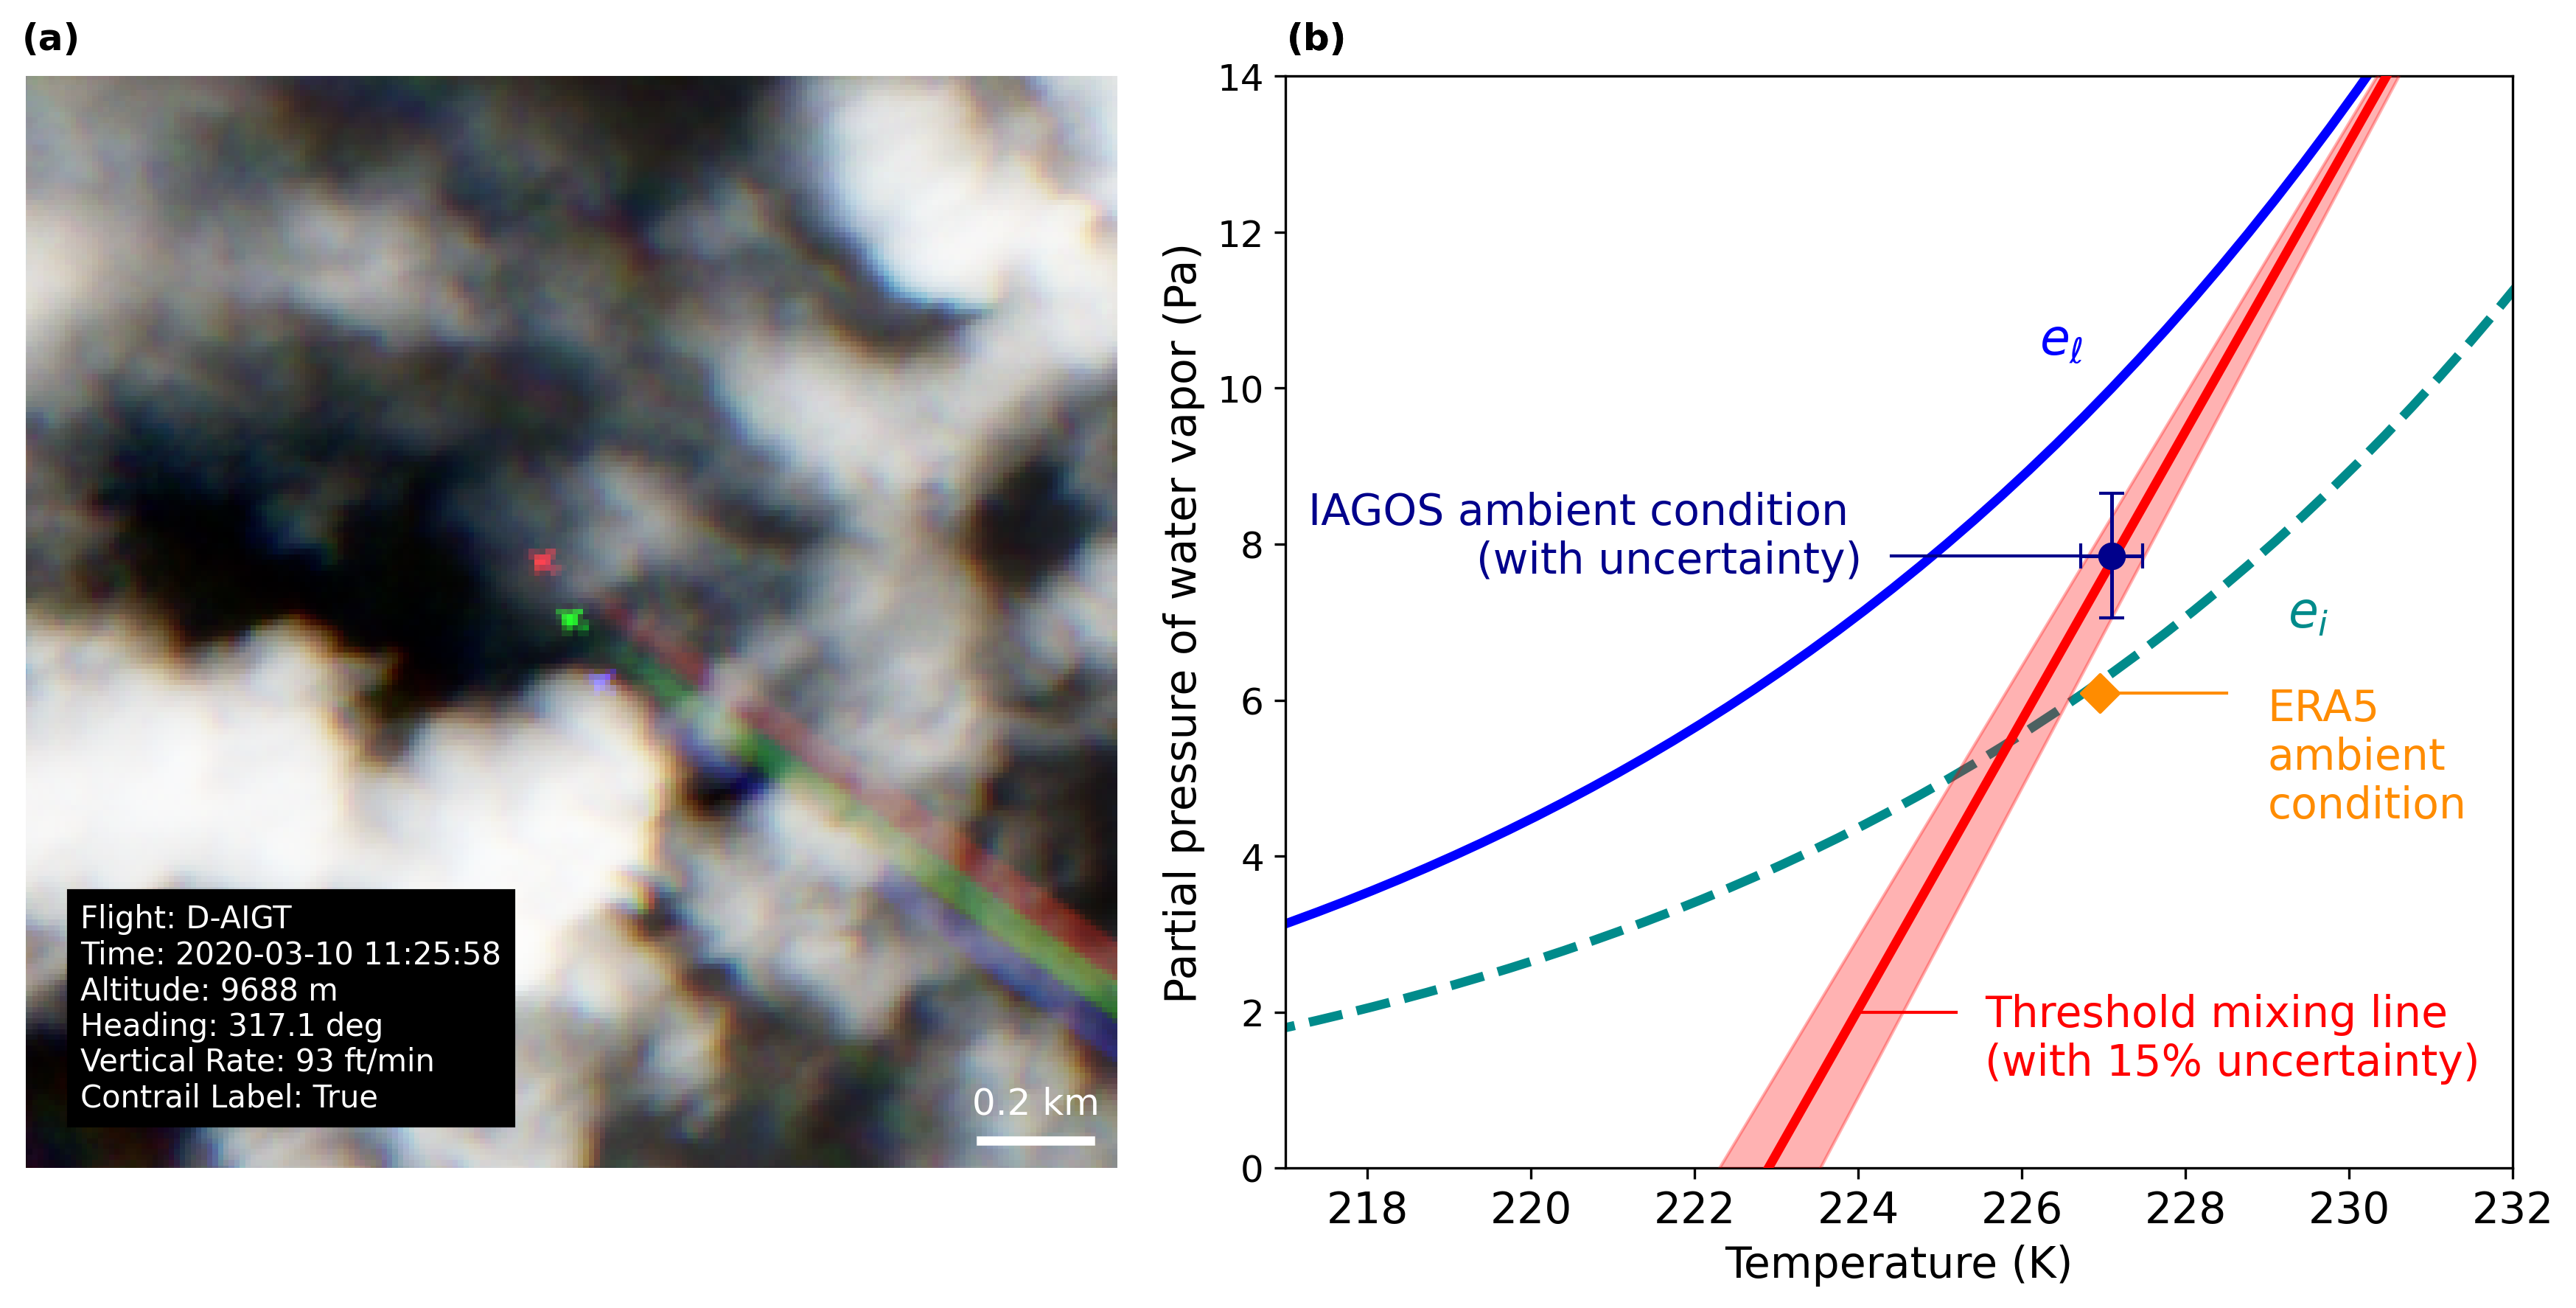

In [28]:
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})


icao24 = row["icao24"]
registration = row["registration"]
sensing_time = row['sensing_time']

fig, (ax_rgb, ax_plot) = plt.subplots(1, 2, figsize=(12, 6), dpi=300, gridspec_kw={'width_ratios': [1.0, 1.1]})

x, y = row["x"], row["y"]

# Load and display the RGB image on the left
if DATASET_LOCATION is not None:

    with open(f"{DATASET_LOCATION}/{row['path']}/metadata.json", "r") as f:
        metadata = json.load(f)

    intersect_directory = DATASET_LOCATION + "/" + row["path"].replace("/metadata.json", "")

    if row["satellite"] == "Sentinel":
        img_rgb = mpimg.imread(f"{intersect_directory}/imagery/rgb_subset.png")
        img_extent = metadata["satellite_data"]["imagery"]["extent_subset"]
        zoom_window = 1000

    elif row["satellite"] == "Landsat":
        # open the image from URL
        with urllib.request.urlopen(metadata["satellite_data"]["imagery"]["thermal_url"]) as response:
            img = Image.open(response)
            img_rgb = np.array(img)
        # img_rgb = mpimg.imread(metadata["satellite_data"]["imagery"]["thermal_url"])
        img_extent = metadata["satellite_data"]["imagery"]["extent"]
        zoom_window = 2000

    ax_rgb.imshow(img_rgb, extent=img_extent)
    ax_rgb.set_xlim(x - zoom_window, x + zoom_window)
    ax_rgb.set_ylim(y - zoom_window, y + zoom_window) 

    ax_rgb.axis('off')  # Hide axes


    if row["satellite"] == "Sentinel":
        scalebar_length = 200  # meters
        bar_x = x + zoom_window - scalebar_length - 50   # little margin from right
        bar_y = y - zoom_window + 50                  # little margin from bottom

        # Draw line
        ax_rgb.plot(
            [bar_x, bar_x + scalebar_length],
            [bar_y, bar_y],
            color="white", linewidth=3
        )

        # Add label
        ax_rgb.text(
            bar_x + scalebar_length / 2,
            bar_y + 100,
            f"{scalebar_length/1000:.1f} km",
            color="white",
            ha="center",
            va="top",
            fontsize=12,
            # backgroundcolor="black"
        )
    elif row["satellite"] == "Landsat":
        scalebar_length = 400  # meters
        bar_x = x + zoom_window - scalebar_length - 100   # little margin from right
        bar_y = y - zoom_window + 100                  # little margin from bottom

        # Draw line
        ax_rgb.plot(
            [bar_x, bar_x + scalebar_length],
            [bar_y, bar_y],
            color="white", linewidth=3
        )

        # Add label
        ax_rgb.text(
            bar_x + scalebar_length / 2,
            bar_y + 200,
            f"{scalebar_length/1000:.1f} km",
            color="white",
            ha="center",
            va="top",
            fontsize=9,
            # backgroundcolor="black"
        )

else:
    # Add placeholder image 
    zoom_window = 1000   
    ax_rgb.text(x, y, 'No Image', color='red', fontsize=12,
                ha='center', va='center')
    ax_rgb.set_xlim(x - zoom_window, x + zoom_window)
    ax_rgb.set_ylim(y - zoom_window, y + zoom_window)
    ax_rgb.axis('off')

ax_rgb.text(
    x - (zoom_window - 100), y - (zoom_window - 100),
    f"Flight: {registration.upper()}\nTime: {sensing_time[:-13]}\nAltitude: {round(row['altitude'])} m\nHeading: {round(row['heading'], 1)} deg\nVertical Rate: {round(row['vertical_rate'])} ft/min\nContrail Label: {row['contrail_formation']}",
    fontsize=10,
    color='white',
    backgroundcolor='black',
    ha='left',
    va='bottom'
)

# create the base plot with saturation vapor pressures and mixing line through T_LM
ax_plot = create_base_plot(ax_plot)

# Base gradient
G1 = thermo.get_mixing_line_gradient_from_LHV(
    row["air_pressure"],
    eta=row["efficiency_PS_IAGOS"]
)

# Temperatures and vapor pressure at Lagrange point
T_LM1 = thermo.get_T_LM(G1)
T_LM1 = T_sat_liquid_high_accuracy(G1)
e_LM1 = thermo.goff_gratch_water(T_LM1)

# Temperature range
T_mixing = np.linspace(200, 300, 100)

# Main mixing line
e_mixing_1 = e_LM1 + G1 * (T_mixing - T_LM1)

ax_plot.plot(
    T_mixing,
    e_mixing_1,
    color='red',
    linewidth=3,
    label=fr"Threshold Mixing Line ($\eta$={round(row['efficiency_PS_IAGOS'], 2)})",
    zorder=4
)

eta_low  = 0.85 * row["efficiency_PS_IAGOS"]
eta_high = 1.15 * row["efficiency_PS_IAGOS"]

# Recompute G1 for both cases
G_low  = thermo.get_mixing_line_gradient_from_LHV(row["air_pressure"], eta=eta_low)
G_high = thermo.get_mixing_line_gradient_from_LHV(row["air_pressure"], eta=eta_high)

# Recompute T_LM and e_LM for both bounds
T_LM_low  = T_sat_liquid_high_accuracy(G_low)
T_LM_high = T_sat_liquid_high_accuracy(G_high)

e_LM_low  = thermo.goff_gratch_water(T_LM_low)
e_LM_high = thermo.goff_gratch_water(T_LM_high)

# Upper and lower mixing lines
e_mixing_low  = e_LM_low  + G_low  * (T_mixing - T_LM_low)
e_mixing_high = e_LM_high + G_high * (T_mixing - T_LM_high)

# Shade the uncertainty region
ax_plot.fill_between(
    T_mixing,
    e_mixing_high,
    e_mixing_low,
    alpha=0.3,
    color='red',
    zorder=3
)


# Plot the ambient conditions
t_ambient_iagos = row["air_temperature_iagos"]
rh_iagos = row["rhl_iagos"]
t_err = row["air_temperature_iagos_error"]
rh_err = row["rhl_iagos_error"]
e_sat = thermo.goff_gratch_water(t_ambient_iagos)

# ambient conditions
e_ambient_iagos = e_sat * rh_iagos

# error in e
e_err = e_sat * rh_err

ax_plot.errorbar(
    t_ambient_iagos,
    e_ambient_iagos,
    xerr=t_err,
    yerr=e_err,
    fmt="o",
    markersize=8,
    color="darkblue",
    ecolor="darkblue",
    elinewidth=1.2,
    capsize=4,
    label="Ambient Condition IAGOS (with uncertainty)",
    zorder=4,
)

t_ambient_era5 = row["air_temperature_era5"]
e_ambient_era5 = thermo.goff_gratch_water(t_ambient_era5) * row["rhl_era5"]
ax_plot.scatter(t_ambient_era5, e_ambient_era5, color="darkorange", label="Ambient Condition ERA5", zorder=4, s=75, marker="D")

ax_plot.set_xlim(217, 232)
ax_plot.set_ylim(0, 14)

ax_rgb.text(x - (zoom_window - 100), y + (zoom_window + 100), "(a)",
        ha="right", va="top", fontsize=12, fontweight="bold")

# Hard coding the annotations
ax_plot.text(0.05, 1.05, "(b)", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=12, fontweight="bold")


ax_plot.text(0.05, 1.05, "(b)", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=12, fontweight="bold")

ax_plot.text(0.57, 0.16, "Threshold mixing line\n(with 15% uncertainty)", color="red", transform=ax_plot.transAxes,
        ha="left", va="top", fontsize=14)
ax_plot.plot([224, 225.2], [2, 2], color="red", linewidth=1)

ax_plot.text(0.47, 0.62, "IAGOS ambient condition \n(with uncertainty)", color="darkblue", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=14)
ax_plot.plot([t_ambient_iagos, 224.4], [e_ambient_iagos, e_ambient_iagos], color="darkblue", linewidth=1)

ax_plot.text(0.80, 0.44, "ERA5\nambient\ncondition", color="darkorange", transform=ax_plot.transAxes,
        ha="left", va="top", fontsize=14)
ax_plot.plot([t_ambient_era5, 228.5], [e_ambient_era5, e_ambient_era5], color="darkorange", linewidth=1)

ax_plot.text(0.65, 0.78, r"$e_\ell$", color="blue", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=16, fontweight="bold")

ax_plot.text(0.85, 0.53, r"$e_i$", color="darkcyan", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=16, fontweight="bold")


ax_plot.grid(False)

plt.tight_layout()
plt.savefig("figures/figA1.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [29]:
row = df.loc[df["scene_id"] == "LC81170462019091LGN00"].iloc[0]


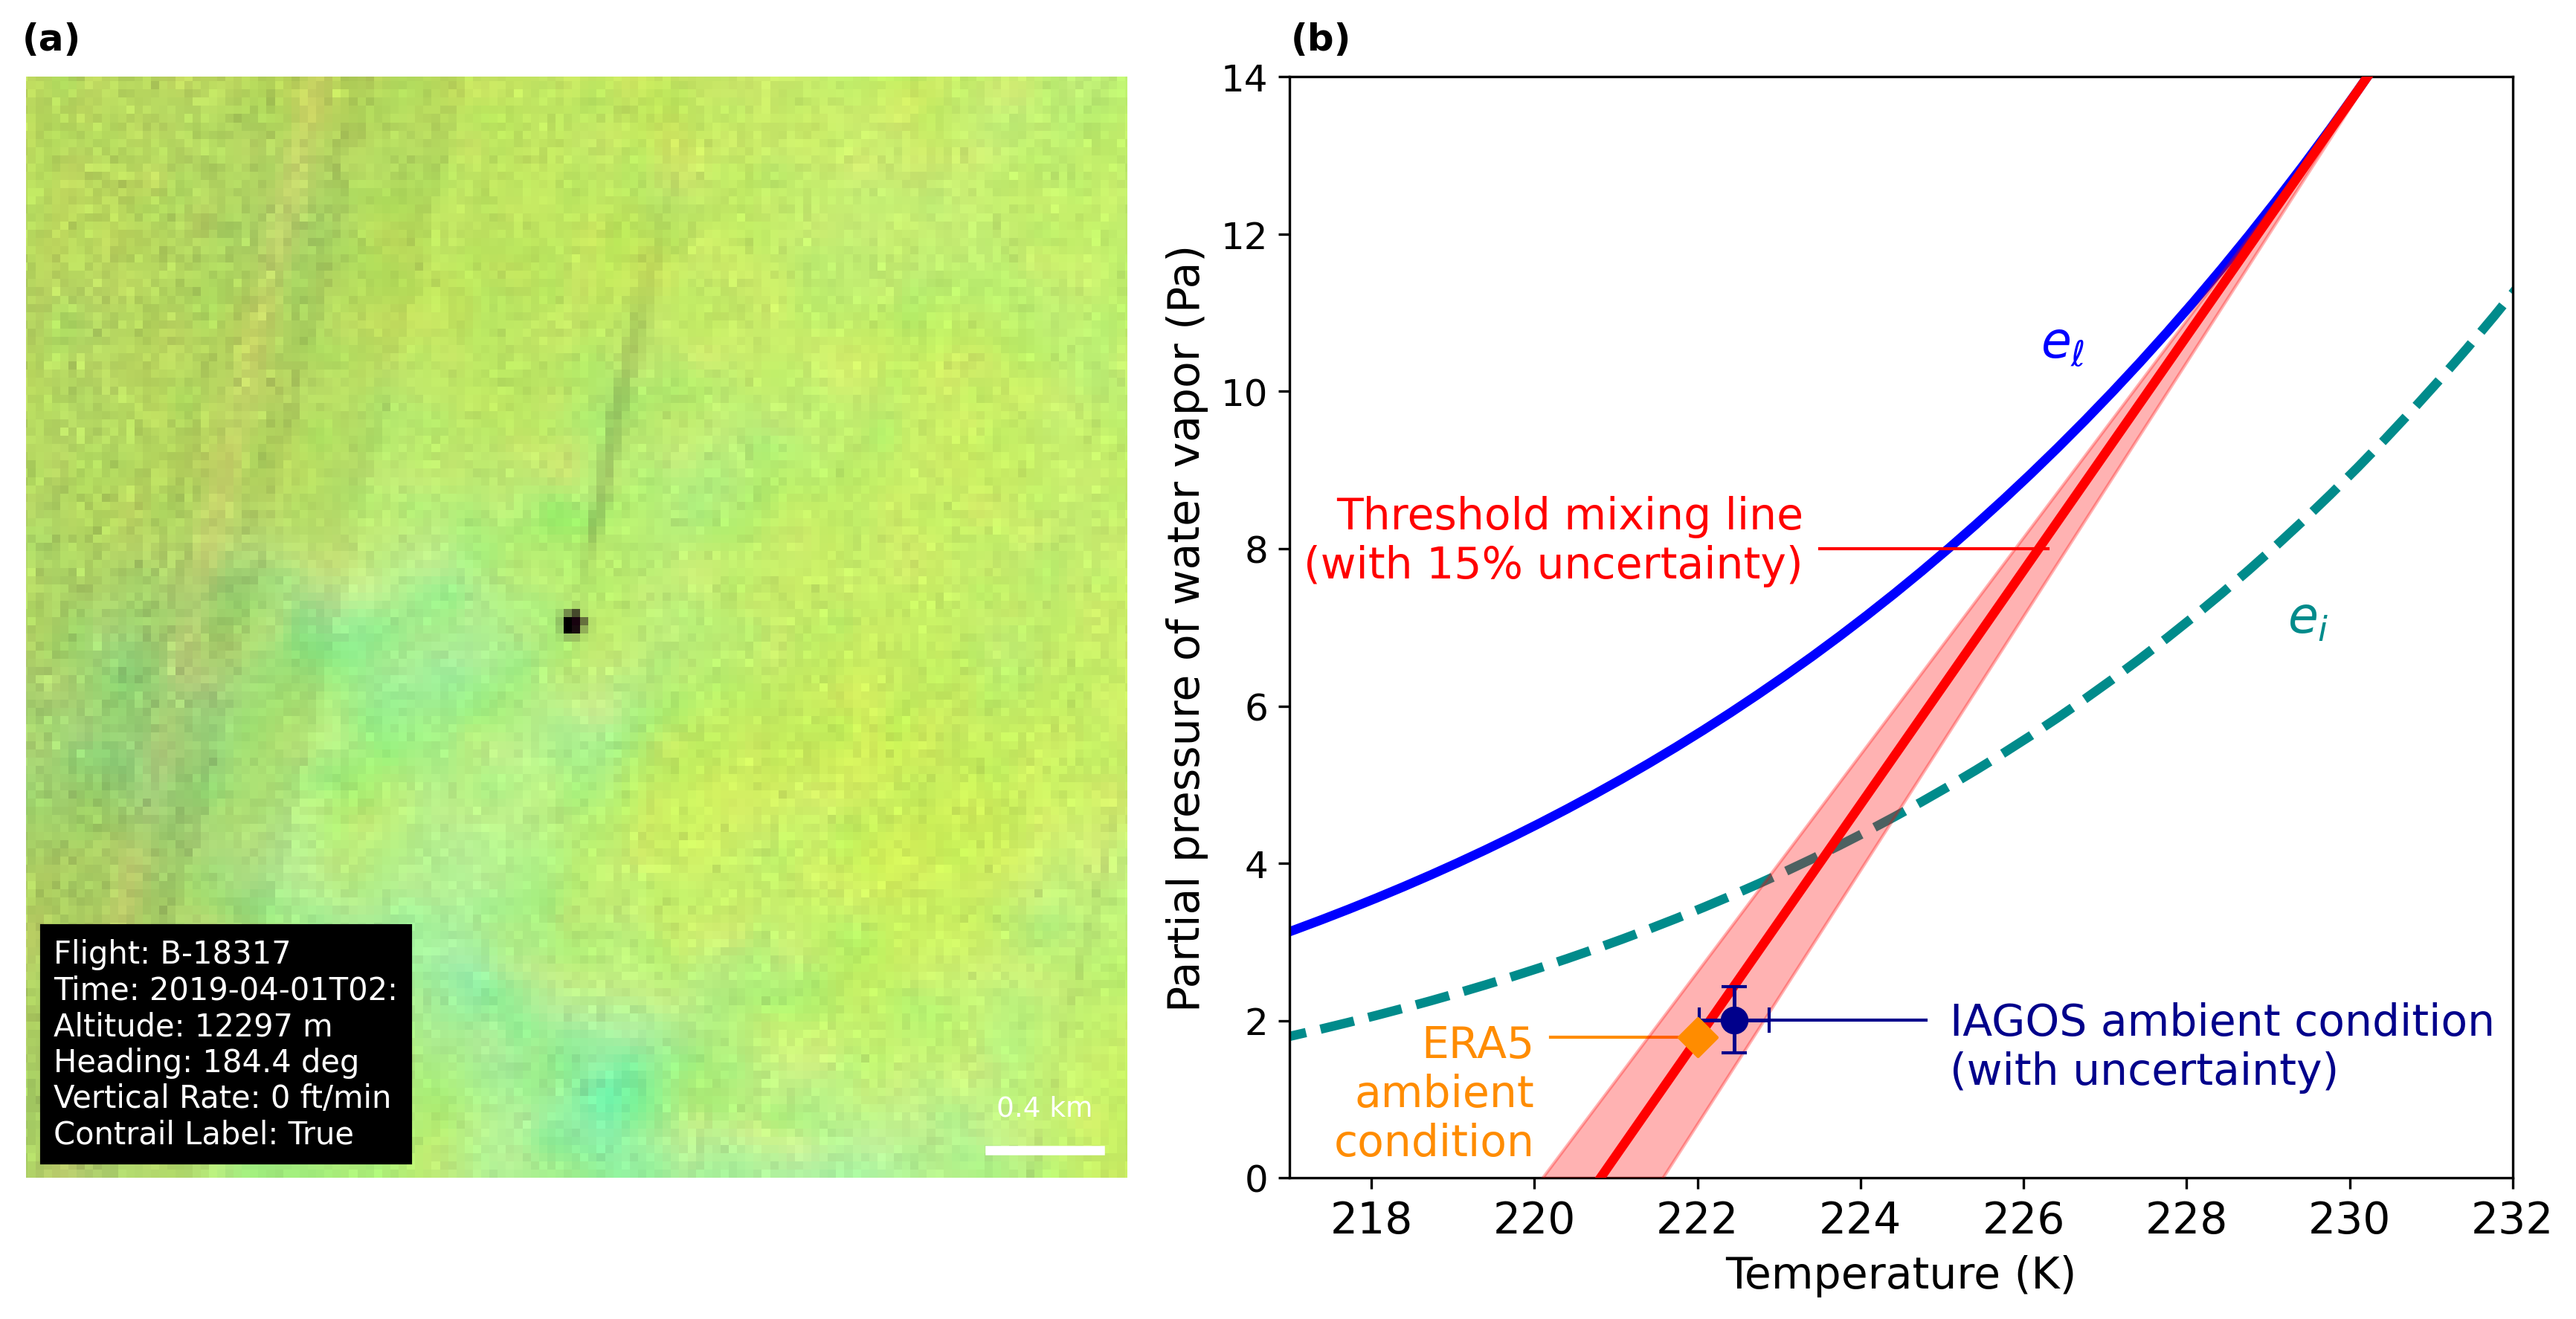

In [30]:
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

icao24 = row["icao24"]
registration = row["registration"]
sensing_time = row['sensing_time']

fig, (ax_rgb, ax_plot) = plt.subplots(1, 2, figsize=(12, 6), dpi=300, gridspec_kw={'width_ratios': [1.0, 1.1]})

x, y = row["x"], row["y"]

# Load and display the RGB image on the left
if DATASET_LOCATION is not None:

    with open(f"{DATASET_LOCATION}/{row['path']}/metadata.json", "r") as f:
        metadata = json.load(f)

    intersect_directory = DATASET_LOCATION + "/" + row["path"].replace("/metadata.json", "")

    if row["satellite"] == "Sentinel":
        img_rgb = mpimg.imread(f"{intersect_directory}/imagery/rgb_subset.png")
        img_extent = metadata["satellite_data"]["imagery"]["extent_subset"]
        zoom_window = 1000

    elif row["satellite"] == "Landsat":
        # open the image from URL
        with urllib.request.urlopen(metadata["satellite_data"]["imagery"]["thermal_url"]) as response:
            img = Image.open(response)
            img_rgb = np.array(img)
        # img_rgb = mpimg.imread(metadata["satellite_data"]["imagery"]["thermal_url"])
        img_extent = metadata["satellite_data"]["imagery"]["extent"]
        zoom_window = 2000

    ax_rgb.imshow(img_rgb, extent=img_extent)
    ax_rgb.set_xlim(x - zoom_window, x + zoom_window)
    ax_rgb.set_ylim(y - zoom_window, y + zoom_window) 

    ax_rgb.axis('off')  # Hide axes


    if row["satellite"] == "Sentinel":
        scalebar_length = 200  # meters
        bar_x = x + zoom_window - scalebar_length - 50   # little margin from right
        bar_y = y - zoom_window + 50                  # little margin from bottom

        # Draw line
        ax_rgb.plot(
            [bar_x, bar_x + scalebar_length],
            [bar_y, bar_y],
            color="white", linewidth=3
        )

        # Add label
        ax_rgb.text(
            bar_x + scalebar_length / 2,
            bar_y + 100,
            f"{scalebar_length/1000:.1f} km",
            color="white",
            ha="center",
            va="top",
            fontsize=12,
            # backgroundcolor="black"
        )
    elif row["satellite"] == "Landsat":
        scalebar_length = 400  # meters
        bar_x = x + zoom_window - scalebar_length - 100   # little margin from right
        bar_y = y - zoom_window + 100                  # little margin from bottom

        # Draw line
        ax_rgb.plot(
            [bar_x, bar_x + scalebar_length],
            [bar_y, bar_y],
            color="white", linewidth=3
        )

        # Add label
        ax_rgb.text(
            bar_x + scalebar_length / 2,
            bar_y + 200,
            f"{scalebar_length/1000:.1f} km",
            color="white",
            ha="center",
            va="top",
            fontsize=9,
            # backgroundcolor="black"
        )

else:
    # Add placeholder image 
    zoom_window = 1000   
    ax_rgb.text(x, y, 'No Image', color='red', fontsize=12,
                ha='center', va='center')
    ax_rgb.set_xlim(x - zoom_window, x + zoom_window)
    ax_rgb.set_ylim(y - zoom_window, y + zoom_window)
    ax_rgb.axis('off')

ax_rgb.text(
    x - (zoom_window - 100), y - (zoom_window - 100),
    f"Flight: {registration.upper()}\nTime: {sensing_time[:-13]}\nAltitude: {round(row['altitude'])} m\nHeading: {round(row['heading'], 1)} deg\nVertical Rate: {round(row['vertical_rate'])} ft/min\nContrail Label: {row['contrail_formation']}",
    fontsize=10,
    color='white',
    backgroundcolor='black',
    ha='left',
    va='bottom'
)

# create the base plot with saturation vapor pressures and mixing line through T_LM
ax_plot = create_base_plot(ax_plot)

# Base gradient
G1 = thermo.get_mixing_line_gradient_from_LHV(
    row["air_pressure"],
    eta=row["efficiency_PS_IAGOS"]
)

# Temperatures and vapor pressure at Lagrange point
T_LM1 = thermo.get_T_LM(G1)
T_LM1 = T_sat_liquid_high_accuracy(G1)
e_LM1 = thermo.goff_gratch_water(T_LM1)

# Temperature range
T_mixing = np.linspace(200, 300, 100)

# Main mixing line
e_mixing_1 = e_LM1 + G1 * (T_mixing - T_LM1)

ax_plot.plot(
    T_mixing,
    e_mixing_1,
    color='red',
    linewidth=3,
    label=fr"Threshold Mixing Line ($\eta$={round(row['efficiency_PS_IAGOS'], 2)})",
    zorder=4
)

eta_low  = 0.85 * row["efficiency_PS_IAGOS"]
eta_high = 1.15 * row["efficiency_PS_IAGOS"]

# Recompute G1 for both cases
G_low  = thermo.get_mixing_line_gradient_from_LHV(row["air_pressure"], eta=eta_low)
G_high = thermo.get_mixing_line_gradient_from_LHV(row["air_pressure"], eta=eta_high)

# Recompute T_LM and e_LM for both bounds
T_LM_low  = T_sat_liquid_high_accuracy(G_low)
T_LM_high = T_sat_liquid_high_accuracy(G_high)

e_LM_low  = thermo.goff_gratch_water(T_LM_low)
e_LM_high = thermo.goff_gratch_water(T_LM_high)

# Upper and lower mixing lines
e_mixing_low  = e_LM_low  + G_low  * (T_mixing - T_LM_low)
e_mixing_high = e_LM_high + G_high * (T_mixing - T_LM_high)

# Shade the uncertainty region
ax_plot.fill_between(
    T_mixing,
    e_mixing_high,
    e_mixing_low,
    alpha=0.3,
    color='red',
    zorder=3
)


# Plot the ambient conditions
t_ambient_iagos = row["air_temperature_iagos"]
rh_iagos = row["rhl_iagos"]
t_err = row["air_temperature_iagos_error"]
rh_err = row["rhl_iagos_error"]
e_sat = thermo.goff_gratch_water(t_ambient_iagos)

# ambient conditions
e_ambient_iagos = e_sat * rh_iagos

# error in e
e_err = e_sat * rh_err

ax_plot.errorbar(
    t_ambient_iagos,
    e_ambient_iagos,
    xerr=t_err,
    yerr=e_err,
    fmt="o",
    markersize=8,
    color="darkblue",
    ecolor="darkblue",
    elinewidth=1.2,
    capsize=4,
    label="Ambient Condition IAGOS (with uncertainty)",
    zorder=4,
)

t_ambient_era5 = row["air_temperature_era5"]
e_ambient_era5 = thermo.goff_gratch_water(t_ambient_era5) * row["rhl_era5"]
ax_plot.scatter(t_ambient_era5, e_ambient_era5, color="darkorange", label="Ambient Condition ERA5", zorder=4, s=75, marker="D")

ax_plot.set_xlim(217, 232)
ax_plot.set_ylim(0, 14)

ax_rgb.text(x - (zoom_window - 200), y + (zoom_window + 200), "(a)",
        ha="right", va="top", fontsize=12, fontweight="bold")

# Hard coding the annotations
ax_plot.text(0.05, 1.05, "(b)", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=12, fontweight="bold")

ax_plot.text(0.42, 0.62, "Threshold mixing line\n(with 15% uncertainty)", color="red", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=14)
ax_plot.plot([223.5, 226.3], [8, 8], color="red", linewidth=1)

ax_plot.text(0.54, 0.16, "IAGOS ambient condition \n(with uncertainty)", color="darkblue", transform=ax_plot.transAxes,
        ha="left", va="top", fontsize=14)
ax_plot.plot([t_ambient_iagos, 224.8], [e_ambient_iagos, e_ambient_iagos], color="darkblue", linewidth=1)

ax_plot.text(0.20, 0.14, "ERA5\nambient\ncondition", color="darkorange", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=14)
ax_plot.plot([220.2, t_ambient_era5], [e_ambient_era5, e_ambient_era5], color="darkorange", linewidth=1)

ax_plot.text(0.65, 0.78, r"$e_\ell$", color="blue", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=16, fontweight="bold")

ax_plot.text(0.85, 0.53, r"$e_i$", color="darkcyan", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=16, fontweight="bold")

ax_plot.grid(False)

plt.tight_layout()
plt.savefig("figures/figA2.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [31]:
row = df.loc[df["scene_id"] == "LC80400292019127LGN00"].iloc[0]


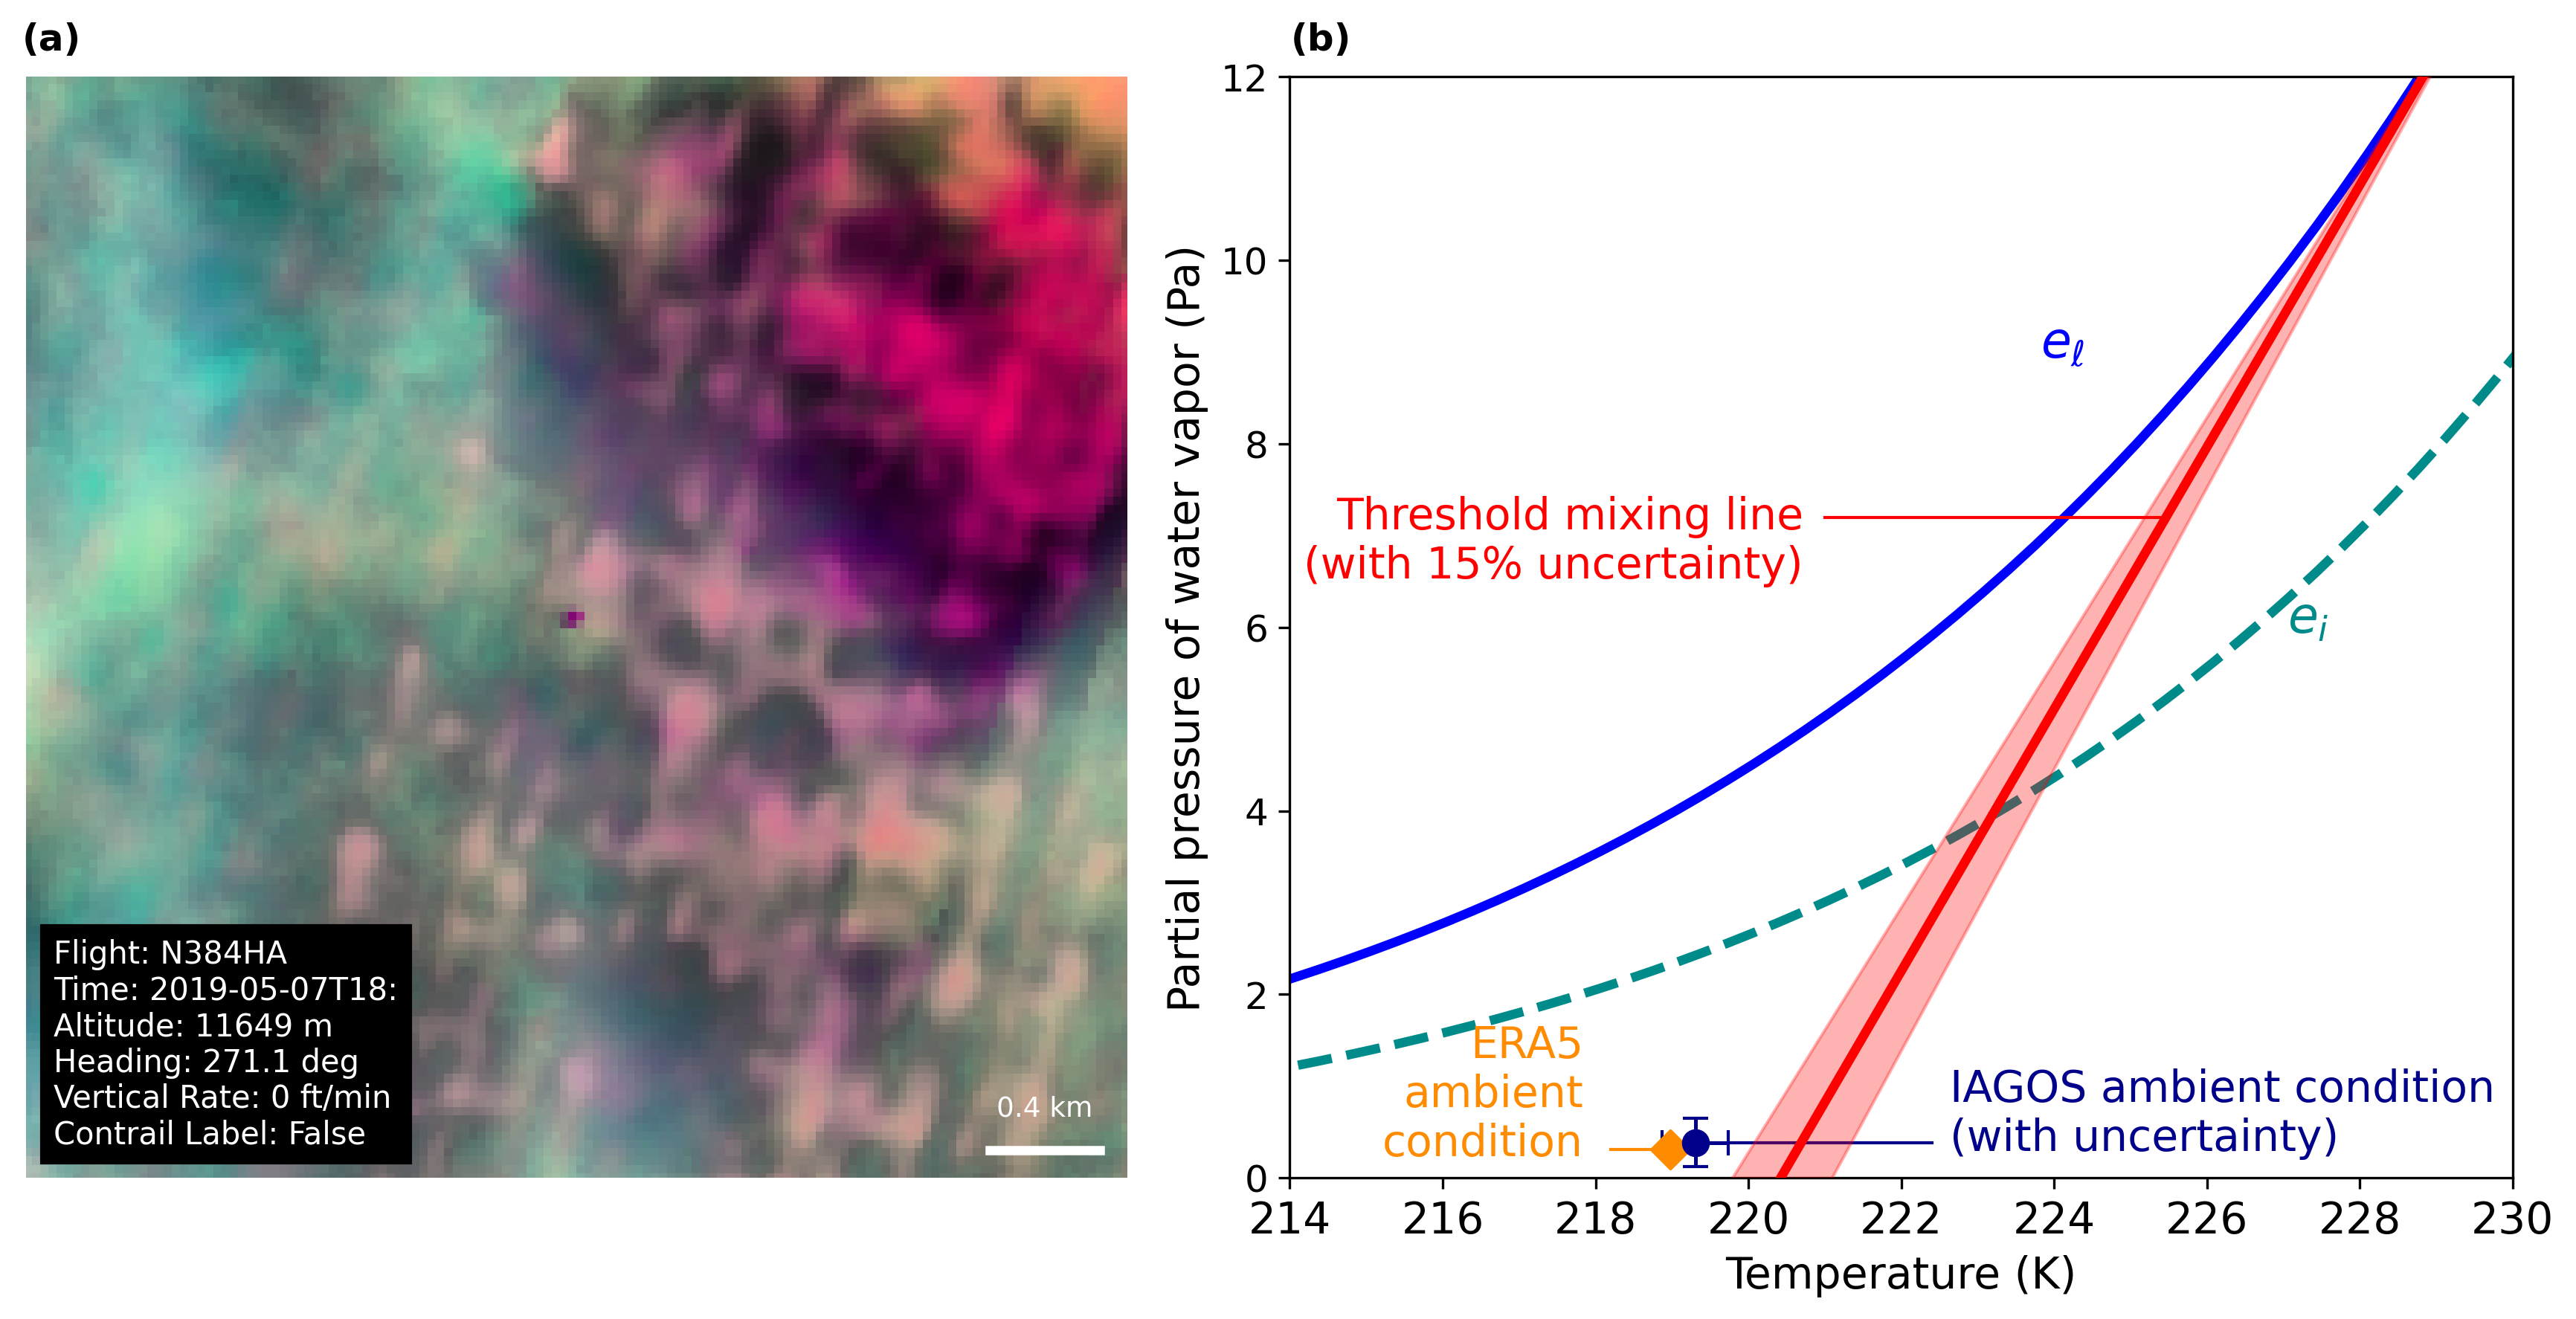

In [32]:
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})


icao24 = row["icao24"]
registration = row["registration"]
sensing_time = row['sensing_time']

fig, (ax_rgb, ax_plot) = plt.subplots(1, 2, figsize=(12, 6), dpi=300, gridspec_kw={'width_ratios': [1.0, 1.1]})

x, y = row["x"], row["y"]

# Load and display the RGB image on the left
if DATASET_LOCATION is not None:

    with open(f"{DATASET_LOCATION}/{row['path']}/metadata.json", "r") as f:
        metadata = json.load(f)

    intersect_directory = DATASET_LOCATION + "/" + row["path"].replace("/metadata.json", "")

    if row["satellite"] == "Sentinel":
        img_rgb = mpimg.imread(f"{intersect_directory}/imagery/rgb_subset.png")
        img_extent = metadata["satellite_data"]["imagery"]["extent_subset"]
        zoom_window = 1000

    elif row["satellite"] == "Landsat":
        # open the image from URL
        with urllib.request.urlopen(metadata["satellite_data"]["imagery"]["thermal_url"]) as response:
            img = Image.open(response)
            img_rgb = np.array(img)
        # img_rgb = mpimg.imread(metadata["satellite_data"]["imagery"]["thermal_url"])
        img_extent = metadata["satellite_data"]["imagery"]["extent"]
        zoom_window = 2000

    ax_rgb.imshow(img_rgb, extent=img_extent)
    ax_rgb.set_xlim(x - zoom_window, x + zoom_window)
    ax_rgb.set_ylim(y - zoom_window, y + zoom_window) 

    ax_rgb.axis('off')  # Hide axes


    if row["satellite"] == "Sentinel":
        scalebar_length = 200  # meters
        bar_x = x + zoom_window - scalebar_length - 50   # little margin from right
        bar_y = y - zoom_window + 50                  # little margin from bottom

        # Draw line
        ax_rgb.plot(
            [bar_x, bar_x + scalebar_length],
            [bar_y, bar_y],
            color="white", linewidth=3
        )

        # Add label
        ax_rgb.text(
            bar_x + scalebar_length / 2,
            bar_y + 100,
            f"{scalebar_length/1000:.1f} km",
            color="white",
            ha="center",
            va="top",
            fontsize=12,
            # backgroundcolor="black"
        )
    elif row["satellite"] == "Landsat":
        scalebar_length = 400  # meters
        bar_x = x + zoom_window - scalebar_length - 100   # little margin from right
        bar_y = y - zoom_window + 100                  # little margin from bottom

        # Draw line
        ax_rgb.plot(
            [bar_x, bar_x + scalebar_length],
            [bar_y, bar_y],
            color="white", linewidth=3
        )

        # Add label
        ax_rgb.text(
            bar_x + scalebar_length / 2,
            bar_y + 200,
            f"{scalebar_length/1000:.1f} km",
            color="white",
            ha="center",
            va="top",
            fontsize=9,
            # backgroundcolor="black"
        )

else:
    # Add placeholder image 
    zoom_window = 1000   
    ax_rgb.text(x, y, 'No Image', color='red', fontsize=12,
                ha='center', va='center')
    ax_rgb.set_xlim(x - zoom_window, x + zoom_window)
    ax_rgb.set_ylim(y - zoom_window, y + zoom_window)
    ax_rgb.axis('off')

ax_rgb.text(
    x - (zoom_window - 100), y - (zoom_window - 100),
    f"Flight: {registration.upper()}\nTime: {sensing_time[:-13]}\nAltitude: {round(row['altitude'])} m\nHeading: {round(row['heading'], 1)} deg\nVertical Rate: {round(row['vertical_rate'])} ft/min\nContrail Label: {row['contrail_formation']}",
    fontsize=10,
    color='white',
    backgroundcolor='black',
    ha='left',
    va='bottom'
)

# create the base plot with saturation vapor pressures and mixing line through T_LM
ax_plot = create_base_plot(ax_plot)

# Base gradient
G1 = thermo.get_mixing_line_gradient_from_LHV(
    row["air_pressure"],
    eta=row["efficiency_PS_IAGOS"]
)

# Temperatures and vapor pressure at Lagrange point
T_LM1 = thermo.get_T_LM(G1)
T_LM1 = T_sat_liquid_high_accuracy(G1)
e_LM1 = thermo.goff_gratch_water(T_LM1)

# Temperature range
T_mixing = np.linspace(200, 300, 100)

# Main mixing line
e_mixing_1 = e_LM1 + G1 * (T_mixing - T_LM1)

ax_plot.plot(
    T_mixing,
    e_mixing_1,
    color='red',
    linewidth=3,
    label=fr"Threshold Mixing Line ($\eta$={round(row['efficiency_PS_IAGOS'], 2)})",
    zorder=4
)

eta_low  = 0.85 * row["efficiency_PS_IAGOS"]
eta_high = 1.15 * row["efficiency_PS_IAGOS"]

# Recompute G1 for both cases
G_low  = thermo.get_mixing_line_gradient_from_LHV(row["air_pressure"], eta=eta_low)
G_high = thermo.get_mixing_line_gradient_from_LHV(row["air_pressure"], eta=eta_high)

# Recompute T_LM and e_LM for both bounds
T_LM_low  = T_sat_liquid_high_accuracy(G_low)
T_LM_high = T_sat_liquid_high_accuracy(G_high)

e_LM_low  = thermo.goff_gratch_water(T_LM_low)
e_LM_high = thermo.goff_gratch_water(T_LM_high)

# Upper and lower mixing lines
e_mixing_low  = e_LM_low  + G_low  * (T_mixing - T_LM_low)
e_mixing_high = e_LM_high + G_high * (T_mixing - T_LM_high)

# Shade the uncertainty region
ax_plot.fill_between(
    T_mixing,
    e_mixing_high,
    e_mixing_low,
    alpha=0.3,
    color='red',
    zorder=3
)


# Plot the ambient conditions
t_ambient_iagos = row["air_temperature_iagos"]
rh_iagos = row["rhl_iagos"]
t_err = row["air_temperature_iagos_error"]
rh_err = row["rhl_iagos_error"]
e_sat = thermo.goff_gratch_water(t_ambient_iagos)

# ambient conditions
e_ambient_iagos = e_sat * rh_iagos

# error in e
e_err = e_sat * rh_err

ax_plot.errorbar(
    t_ambient_iagos,
    e_ambient_iagos,
    xerr=t_err,
    yerr=e_err,
    fmt="o",
    markersize=8,
    color="darkblue",
    ecolor="darkblue",
    elinewidth=1.2,
    capsize=4,
    label="Ambient Condition IAGOS (with uncertainty)",
    zorder=4,
)

t_ambient_era5 = row["air_temperature_era5"]
e_ambient_era5 = thermo.goff_gratch_water(t_ambient_era5) * row["rhl_era5"]
ax_plot.scatter(t_ambient_era5, e_ambient_era5, color="darkorange", label="Ambient Condition ERA5", zorder=4, s=75, marker="D")

ax_plot.set_xlim(214, 230)
ax_plot.set_ylim(0, 12)

ax_rgb.text(x - (zoom_window - 200), y + (zoom_window + 200), "(a)",
        ha="right", va="top", fontsize=12, fontweight="bold")

# Hard coding the annotations

ax_plot.text(0.05, 1.05, "(b)", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=12, fontweight="bold")

ax_plot.text(0.42, 0.62, "Threshold mixing line\n(with 15% uncertainty)", color="red", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=14)
ax_plot.plot([221, 225.5], [7.2, 7.2], color="red", linewidth=1)

ax_plot.text(0.54, 0.10, "IAGOS ambient condition \n(with uncertainty)", color="darkblue", transform=ax_plot.transAxes,
        ha="left", va="top", fontsize=14)
ax_plot.plot([t_ambient_iagos, 222.4], [e_ambient_iagos, e_ambient_iagos], color="darkblue", linewidth=1)

ax_plot.text(0.24, 0.14, "ERA5\nambient\ncondition", color="darkorange", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=14)
ax_plot.plot([218.2, t_ambient_era5], [e_ambient_era5, e_ambient_era5], color="darkorange", linewidth=1)

ax_plot.text(0.65, 0.78, r"$e_\ell$", color="blue", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=16, fontweight="bold")

ax_plot.text(0.85, 0.53, r"$e_i$", color="darkcyan", transform=ax_plot.transAxes,
        ha="right", va="top", fontsize=16, fontweight="bold")

ax_plot.grid(False)

plt.tight_layout()
plt.savefig("figures/figA3.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()